In [14]:
from re import T
import pandas as pd
import os
import sys
import numpy as np
import math

# Matching dictionary for team names between events and tracking data
TEAM_NAMES = {'Canada': 'Olympic (Women) - Canada', 
              'USA': 'Olympic (Women) - United States',
              'Finland': 'Olympic (Women) - Finland',
              'ROC': 'Olympic (Women) - Olympic Athletes from Russia',
              'Switzerland': 'Olympic (Women) - Switzerland'}

# Max number of frames to skip in velocity calculations
MAX_FRAME_JUMP = 5

In [16]:
# This is for convenience to match our wd just in case the notebook is located elsewhere
print(os.getcwd())
os.chdir(r'C:\Users\carli\Documents\Hockey Research\BDC\2022\Big-Data-Cup-2022')

C:\Users\carli\Documents\Hockey Research\BDC\2022\Big-Data-Cup-2022\code\data_manipulation


In [17]:
def get_names_date(game):
    # get's team names and date from the game file name
    spl = game.split(' ')
    date_comps = spl[0].split('-')
    date = '{}/{}/{}'.format(*[dt.strip('0') for dt in date_comps[::-1]])
    team_1 = TEAM_NAMES[spl[1]]
    team_2 = TEAM_NAMES[spl[3]]
    
    return team_1, team_2, date
    
def get_speed(track):
    # calculate velocity using displacement between frames
    assert (track['track_id'] == track['track_id'].iloc[0]).all()
    try:
        frame_diff = np.diff(track['frame_id'])
        nonvalid_speed = np.concatenate([[True],frame_diff>MAX_FRAME_JUMP])
        next_valid_speed = np.concatenate([frame_diff<=MAX_FRAME_JUMP,[False]])
        repl = nonvalid_speed & next_valid_speed
        idx = np.where(repl)[0]+1
        
        x_spd = np.concatenate([[np.nan],np.diff(track['x_ft'])/frame_diff])*30
        y_spd = np.concatenate([[np.nan],np.diff(track['y_ft'])/frame_diff])*30
        
        x_spd[repl] = x_spd[idx]
        y_spd[repl] = y_spd[idx]

    except Exception as e:
        print(np.diff(track['frame_id']))
        raise

    return(x_spd, y_spd)

In [223]:
def get_pp_tracking(power_play_info_file = 'pp_info.csv',
    play_by_play_data_file = 'pxp_womens_oly_2022_v2.csv',
    tracking_dir = 'data',
    pbp_dir = 'data'):
    '''
    Function for reading tracking and event data and matching relevant tracks to events
    '''
    play_by_play_data = pd.read_csv(os.path.join(tracking_dir,play_by_play_data_file))
     # Adjusting clock seconds to include period so the game starts at 3600 and ends at 0 
    # (there are no overtime periods in this data but if there will be in the future this will require handeling)
    play_by_play_data.loc[:,'clock_seconds'] = (3-play_by_play_data.period) * 1200 + play_by_play_data.clock_seconds
    play_by_play_data['offensive_zone_event'] = False
    play_by_play_data.loc[play_by_play_data['x_coord']> 100,'offensive_zone_event'] = True
    
    #mirroring indices
    wrong_way_teams = ["Olympic (Women) - Canada", "Olympic (Women) - United States"]
    mirror_indices = (
        (
            # need to mirror the home team in even-numbered periods
            ((play_by_play_data.venue == "home") & ~(play_by_play_data.period % 2))
            # and the away team in odd-numbered
            | ((play_by_play_data.venue == "away") & (play_by_play_data.period % 2))
        )
        # flipping things in the Canada-USA game
        ^ (play_by_play_data.team_name.isin(wrong_way_teams) & play_by_play_data.opp_team_name.isin(wrong_way_teams))
    )
    
    # coordinate correction - Carlie

    wrong_way_teams = [
        "Olympic (Women) - Canada", "Olympic (Women) - United States"
    ]
    mirror_indices_2 = (
        (
            # need to mirror the home team in odd-numbered periods
            ((play_by_play_data.venue == "home") & (play_by_play_data.period % 2))
            # and the away team in even-numbered
            | ((play_by_play_data.venue == "away") & ~(play_by_play_data.period % 2))
        )
        # flipping things in the Canada-USA game
        ^ (play_by_play_data.team_name.isin(wrong_way_teams)
           & play_by_play_data.opp_team_name.isin(wrong_way_teams)))

    # a rink is 85 ft wide
    coord_columns = ["y_coord", "y_coord_2"]
    play_by_play_data.loc[mirror_indices_2,
            coord_columns] = 85 - play_by_play_data.loc[mirror_indices_2, coord_columns]

    ######

    # reverse flip for away team in even-number period in SWI-OAR and CAN-SWI
    reflip_1 = [
        'Olympic (Women) - Olympic Athletes from Russia',
        'Olympic (Women) - Switzerland'
    ]
    reflip_2 = ['Olympic (Women) - Canada', 'Olympic (Women) - Switzerland']

    mirror_back_indices = (
        # and the away team in even-numbered
        ((play_by_play_data.venue == "away") & ~(play_by_play_data.period % 2))
        & ((play_by_play_data.team_name.isin(reflip_1)
            & play_by_play_data.opp_team_name.isin(reflip_1)) |
           (play_by_play_data.team_name.isin(reflip_2)
            & play_by_play_data.opp_team_name.isin(reflip_2))))

    # a rink is 85 ft wide
    coord_columns = ["y_coord", "y_coord_2"]
    play_by_play_data.loc[mirror_back_indices, coord_columns] = 85 - play_by_play_data.loc[mirror_back_indices, coord_columns]


    # a rink is 200 ft long
    coord_columns = ["x_coord", "x_coord_2"]
    play_by_play_data.loc[mirror_indices, coord_columns] = 200 - play_by_play_data.loc[mirror_indices, coord_columns]
    
    power_play_info = pd.read_csv(os.path.join(pbp_dir,power_play_info_file))
    power_play_info.loc[:,'start_game_clock_seconds'] +=  (3-power_play_info.start_period)*1200
    power_play_info.loc[:,'end_game_clock_seconds'] +=  (3-power_play_info.end_period)*1200
    
    power_play_info['relevant_events'] = np.nan

    # Big data frame for all games and power plays
    relevant_eventses = []

    # Run through all the games and powerplays
    for ix, pp in power_play_info.iterrows():
        relevant_events = None
        game = pp['game_name']
        # print(game)
        #if game!='2022-02-14 Finland at USA':
        
        # Read relevant files
        game_files = os.listdir(os.path.join(tracking_dir,game))
        tracking_data_name = os.path.join(tracking_dir,game,f'{game} P{pp["end_period"]} PP{pp["penalty_number"]}.csv')
        tracking_info_name = os.path.join(tracking_dir,game,f'videoShotsInfo_{game} P{pp["end_period"]} PP{pp["penalty_number"]}.csv')
        roster_info_name = os.path.join(tracking_dir, game, f'{game} roster.csv')
        roster_info = pd.read_csv(roster_info_name, index_col = 0)
        
        # Get team names
        away, _ , home = game.split(' ')[-3:]
        roster_info.loc[roster_info['team']=='away','team'] = away
        roster_info.loc[roster_info['team']=='home','team'] = home

        # mark goalies for each team that is playing (used later)
        goalie = {f'{rf["team"]}_{rf["jn"]}':rf['position']=='Goalie' for _,rf in roster_info.iterrows()}

        # read entire tracking file and calculate speeds and skating directions
        if os.path.split(tracking_data_name)[1] in game_files:
            print(tracking_data_name)
            tracking_data = pd.read_csv(tracking_data_name)
            # add column identifiyng whether each track belongs to a goal keeper
            tracking_data['goalie'] = [goalie[f'{tr["team_name"]}_{tr["jersey_number"]}'] if f'{tr["team_name"]}_{tr["jersey_number"]}' in goalie.keys() else False for _,tr in tracking_data.iterrows()]
            tracking_data['team_type'] = np.nan
            tracking_data.loc[tracking_data['team_name']==away,'team_type'] = 'away'
            tracking_data.loc[tracking_data['team_name']==home,'team_type'] = 'home'
            
            tracking_data['vel_x'] = np.nan
            tracking_data['vel_y'] = np.nan
            tracking_data['angle'] = np.nan
            tr_ids = tracking_data.track_id.unique()
            # Calculate velocity and skating angle
            for tr_id in tr_ids:
                idxs = tracking_data.track_id==tr_id
                track = tracking_data.loc[idxs]
                if len(track) <= 5:
                    continue
                x_spd,y_spd = get_speed(track)
                tracking_data.loc[idxs,'vel_x'] = x_spd
                tracking_data.loc[idxs,'vel_y'] = y_spd
                tracking_data['angle'] = np.arctan2(tracking_data['vel_y'],tracking_data['vel_x'])
            tracking_info = pd.read_csv(tracking_info_name)
        else:
            # Can't file this tracking file
            print('Tracking file missing:\n{}'.format(tracking_data_name))
            relevant_eventses.append(None)
            continue
        team_1, team_2, date = get_names_date(game)
       
        # filter relevant plays for current period and power play
        relevant_events = play_by_play_data.loc[(play_by_play_data['game_date'] == date) & 
                                    ((play_by_play_data['team_name'] == team_1) |
                                        (play_by_play_data['team_name'] == team_2))]

        # Because of the time adjustment for the play-by-play and power play data we only need to check the time, not the period
        relevant_events = relevant_events.loc[(relevant_events['clock_seconds'] <= pp['start_game_clock_seconds']) &
                                        (relevant_events['clock_seconds'] >= pp['end_game_clock_seconds']) ]
                                        
        # Placeholders for time to next shot and time to next goal
        relevant_events.index = np.arange(0, len(relevant_events.index), dtype = 'int')
        relevant_events['time_to_shot'] = np.ones(len(relevant_events)) * np.inf
        relevant_events['time_to_goal'] = np.ones(len(relevant_events)) * np.inf
        shots = relevant_events.loc[relevant_events.event == 'Shot']
        goals = shots.loc[shots.event_successful == 't']
        # Calculating the time to next shot, goal
        while len(shots):
            ix = (relevant_events['clock_seconds']>=shots.iloc[0].clock_seconds) & (relevant_events['time_to_shot'] > 100000)
            relevant_events.loc[ix,'time_to_shot'] = relevant_events.loc[ix,'clock_seconds'] - shots.iloc[0].clock_seconds
            shots = shots.iloc[1:,]
        while len(goals):
            ix = (relevant_events['clock_seconds']>=goals.iloc[0].clock_seconds) & (relevant_events['time_to_goal'] > 100000)
            relevant_events.loc[ix,'time_to_goal'] = relevant_events.loc[ix,'clock_seconds'] - goals.iloc[0].clock_seconds
            goals = shots.iloc[1:,]
        
        # Matching names and jersey numbers
        pl1_jn = roster_info.loc[relevant_events['player_name'],'jn']
        pl1_jn.index = relevant_events.index

        pl2_exists = list(relevant_events['player_name_2'].notna())
        pl2_jn = roster_info.loc[relevant_events['player_name_2'][pl2_exists],'jn']

        pl2_jn.index = relevant_events.index[pl2_exists]
        relevant_events['Player_1_num'] = pl1_jn
        relevant_events['Player_2_num'] = pl2_jn
        
        tracks = []
        
        # Giving each event the tracks between the beginning and end of the event (if we have the end, otherwise just the frame of the event)
        for rw, event in relevant_events.iterrows():
            fr_id_1 = event['frame_id_1']
            if pd.isna(fr_id_1):
                tracks.append(None)
                continue
            fr_id_2 = event['frame_id_2']
            if pd.notna(fr_id_2):
                tracks.append(tracking_data.loc[(tracking_data['frame_id']>=fr_id_1) &
                                                     (tracking_data['frame_id']<=fr_id_2)])
            else:
                tracks.append(tracking_data.loc[tracking_data['frame_id']==fr_id_1])

        # Assign track to the relevant event            
        relevant_events['tracks'] = tracks

        # Add the current event to the final dataframe for this pp
        relevant_eventses.append(relevant_events)
    # Add a column of relevant events to the power play infor dataframe
    power_play_info['relevant_events'] = relevant_eventses
    return power_play_info


In [224]:
# Read tracking and event data
relevant_events = get_pp_tracking()
relevant_events.head()

data\2022-02-08 Canada at USA\2022-02-08 Canada at USA P1 PP1.csv
data\2022-02-08 Canada at USA\2022-02-08 Canada at USA P1 PP2.csv
data\2022-02-08 Canada at USA\2022-02-08 Canada at USA P2 PP3.csv
Tracking file missing:
data\2022-02-08 Canada at USA\2022-02-08 Canada at USA P2 PP4.csv
data\2022-02-08 Canada at USA\2022-02-08 Canada at USA P2 PP5.csv
data\2022-02-08 Canada at USA\2022-02-08 Canada at USA P3 PP6.csv
data\2022-02-08 Canada at USA\2022-02-08 Canada at USA P3 PP7.csv
data\2022-02-08 ROC at Finland\2022-02-08 ROC at Finland P1 PP1.csv
data\2022-02-08 ROC at Finland\2022-02-08 ROC at Finland P2 PP2.csv
Tracking file missing:
data\2022-02-08 ROC at Finland\2022-02-08 ROC at Finland P2 PP3.csv
Tracking file missing:
data\2022-02-08 ROC at Finland\2022-02-08 ROC at Finland P2 PP4.csv
data\2022-02-08 ROC at Finland\2022-02-08 ROC at Finland P2 PP5.csv
data\2022-02-08 ROC at Finland\2022-02-08 ROC at Finland P3 PP6.csv
data\2022-02-12 Switzerland at ROC\2022-02-12 Switzerland at 

,game_name,penalty_number,start_video_clock_seconds,end_video_clock_seconds,start_period,end_period,start_game_clock_seconds,end_game_clock_seconds,relevant_events
0,2022-02-08 Canada at USA,1,1278,1314,1,1,2786,2750,game_date season_year ...
1,2022-02-08 Canada at USA,2,1624,1744,1,1,2616,2496,game_date season_year ...
2,2022-02-08 Canada at USA,3,409,562,2,2,2191,2071,game_date season_year ...
3,2022-02-08 Canada at USA,4,898,898,2,2,1813,1813,None
4,2022-02-08 Canada at USA,5,1690,1927,2,2,1472,1352,game_date season_year ...


In [75]:
# Example of tracking data for one event
print(relevant_events.loc[0,'relevant_events'].tracks.iloc[6])
print(relevant_events.loc[0,'relevant_events'])

     frame_id  period  track_id team_id team_name  jersey_number        x_ft  \
301       344       1         3    Dark       USA             35  185.378708   
302       344       1         2    Dark       USA              2  178.061495   
303       344       1         4   Light    Canada             19  190.091633   
304       344       1         1   Light    Canada              6  169.637361   
305       344       1         7    Dark       USA              5  185.094211   
..        ...     ...       ...     ...       ...            ...         ...   
509       370       1         7    Dark       USA              5  176.362805   
510       370       1         9   Light    Canada             23  131.460731   
511       370       1         3    Dark       USA             35  181.717333   
512       370       1        13   Light    Canada             29  136.055357   
513       370       1         8    Dark       USA             25  145.369410   

          y_ft  video_shot  game_second

In [76]:
# Save to JSON to read from R
#relevant_events.to_json(r'data/BDC_2022_all_data.json')

In [232]:
# Filter for direct passes only

relevant_events2 = relevant_events.loc[~relevant_events['relevant_events'].isna()]
the_truth = (relevant_events2.loc[0,'relevant_events']['offensive_zone_event'] == True)&(~relevant_events2.loc[0,'relevant_events']['tracks'].isna())
r0_direct = relevant_events2.loc[0,'relevant_events'].loc[the_truth]

for r in relevant_events2.index[1:]:
    r_the_truth = (relevant_events2.loc[r,'relevant_events']['offensive_zone_event'] == True)&(~relevant_events2.loc[r,'relevant_events']['tracks'].isna())
    r_new_direct = relevant_events2.loc[r,'relevant_events'].loc[r_the_truth]
    r0_direct=pd.concat([r0_direct, r_new_direct])
r0_direct = r0_direct.reset_index(drop=True)
r0_direct.shape

(735, 30)

In [233]:
# Save direct passes to R to read later
#r0_direct.to_json(r'data/BDC_2022_all_direct_wFrames.json')

In [234]:
# Filter to keep only one frame (makes JSON smaller for further analysis)
truth2 = r0_direct.loc[0,'tracks']['frame_id']==r0_direct.frame_id_1[0]
r_frame_direct = r0_direct.loc[0,'tracks'].loc[truth2]
r_direct_oneFrame = []

for r in r0_direct.index:
    r_truth2 = r0_direct.loc[r,'tracks']['frame_id']==r0_direct.frame_id_1[r]
    r2_frame_direct = r0_direct.loc[r,'tracks'].loc[r_truth2]
    r_direct_oneFrame.append(r2_frame_direct)

r0_direct['tracks']=r_direct_oneFrame
r0_direct = r0_direct.reset_index(drop=True)
print(r0_direct.columns)

r0_direct.rename(columns={'frame_id_1':'frame_id'}, inplace=True)
#r0_direct[''] = 


max_tracks = 0
for i in range(len(r0_direct)):
    row_track_len = len(r0_direct.loc[i,'tracks'])
    if row_track_len > max_tracks:
        max_tracks = row_track_len
        
print(r0_direct.loc[0,'frame_id'])
print(r0_direct.loc[0,'tracks'].frame_id)

Index(['game_date', 'season_year', 'team_name', 'opp_team_name', 'venue',
       'period', 'clock_seconds', 'situation_type', 'goals_for',
       'goals_against', 'player_name', 'event', 'event_successful', 'x_coord',
       'y_coord', 'event_type', 'player_name_2', 'x_coord_2', 'y_coord_2',
       'event_detail_1', 'event_detail_2', 'event_detail_3', 'frame_id_1',
       'frame_id_2', 'offensive_zone_event', 'time_to_shot', 'time_to_goal',
       'Player_1_num', 'Player_2_num', 'tracks'],
      dtype='object')
344.0
301    344
302    344
303    344
304    344
305    344
306    344
307    344
Name: frame_id, dtype: int64


In [235]:
# split the dataframe into two separate dataframes for home and away
tracking_data = pd.DataFrame(columns=['player_diff','frame_id','away_angle_1', 'away_goalie_1', 'away_jersey_number_1',
       'away_team_name_1', 'away_vel_x_1', 'away_vel_y_1', 'away_x_ft_1',
       'away_y_ft_1', 'away_angle_2', 'away_goalie_2', 'away_jersey_number_2',
       'away_team_name_2', 'away_vel_x_2', 'away_vel_y_2', 'away_x_ft_2',
       'away_y_ft_2', 'away_angle_3', 'away_goalie_3', 'away_jersey_number_3',
       'away_team_name_3', 'away_vel_x_3', 'away_vel_y_3', 'away_x_ft_3',
       'away_y_ft_3', 'away_angle_4', 'away_goalie_4', 'away_jersey_number_4',
       'away_team_name_4', 'away_vel_x_4', 'away_vel_y_4', 'away_x_ft_4',
       'away_y_ft_4', 'away_angle_5', 'away_goalie_5', 'away_jersey_number_5',
       'away_team_name_5', 'away_vel_x_5', 'away_vel_y_5', 'away_x_ft_5',
       'away_y_ft_5','away_angle_6', 'away_goalie_6', 'away_jersey_number_6',
       'away_team_name_6', 'away_vel_x_6', 'away_vel_y_6', 'away_x_ft_6',
       'away_y_ft_6', 'home_angle_1', 'home_goalie_1',
       'home_jersey_number_1', 'home_team_name_1', 'home_vel_x_1',
       'home_vel_y_1', 'home_x_ft_1', 'home_y_ft_1', 'home_angle_2',
       'home_goalie_2', 'home_jersey_number_2', 'home_team_name_2',
       'home_vel_x_2', 'home_vel_y_2', 'home_x_ft_2', 'home_y_ft_2',
       'home_angle_3', 'home_goalie_3', 'home_jersey_number_3',
       'home_team_name_3', 'home_vel_x_3', 'home_vel_y_3', 'home_x_ft_3',
       'home_y_ft_3', 'home_angle_4', 'home_goalie_4', 'home_jersey_number_4',
       'home_team_name_4', 'home_vel_x_4', 'home_vel_y_4', 'home_x_ft_4',
       'home_y_ft_4', 'home_angle_5', 'home_goalie_5', 'home_jersey_number_5',
       'home_team_name_5', 'home_vel_x_5', 'home_vel_y_5', 'home_x_ft_5',
       'home_y_ft_5', 'home_angle_6', 'home_goalie_6', 'home_jersey_number_6',
       'home_team_name_6', 'home_vel_x_6', 'home_vel_y_6', 'home_x_ft_6',
       'home_y_ft_6'])
for row in range(len(r0_direct)):
    away_tracking = r0_direct.loc[row, 'tracks'].loc[r0_direct.loc[row,'tracks'].team_type == "away"].drop(columns=["frame_id","track_id","period","team_id","video_shot","game_seconds"]).reset_index(drop=True)
    away_player_len = len(away_tracking)
    away = away_tracking.set_index(['team_type',away_tracking.groupby(['team_type']).cumcount()+1]).unstack().sort_index(level=1, axis=1)
    away.columns = away.columns.map('{0[0]}_{0[1]}'.format)
    away = away.add_prefix('away_')
    away.reset_index(drop=True)
    if away_player_len != int(away.columns[-1][-1]):
        print(row)
        print(False)
    away['frame_id'] = r0_direct.loc[row, 'tracks'].reset_index().loc[0,'frame_id']
    home_tracking = r0_direct.loc[row, 'tracks'].loc[r0_direct.loc[row,'tracks'].team_type == "home"].drop(columns=["frame_id","track_id","period","team_id","video_shot","game_seconds"]).reset_index(drop=True)
    home_player_len = len(home_tracking)
    home = home_tracking.set_index(['team_type',home_tracking.groupby(['team_type']).cumcount()+1]).unstack().sort_index(level=1, axis=1)
    home.columns = home.columns.map('{0[0]}_{0[1]}'.format)
    home = home.add_prefix('home_')
    home.reset_index(drop=True)
    if home_player_len != int(home.columns[-1][-1]):
        print(row)
        print(False)
    home['frame_id'] = r0_direct.loc[row, 'tracks'].reset_index().loc[0,'frame_id']
    tracking = away.merge(home, on="frame_id", how="left")
    if (r0_direct.loc[row, 'venue'] == 'away'):
        tracking['player_diff'] = away_player_len - home_player_len
    elif (r0_direct.loc[row, 'venue'] == 'home'):
        tracking['player_diff'] =  home_player_len - away_player_len
    else:
        print("Player Diff Broken")
        break
    tracking_data = tracking_data.append(tracking)
    print(tracking_data)

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   

  away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  ...  \
0           Canada     -9.628467      7.603144   190.091633    69.393926  ...   

   home_x_ft_5 home_y_ft_5 home_angle_6 home_goalie_6  home_jersey_number_6  \
0     155.3593   51.262719          NaN           NaN                   NaN   

   home_team_name_6  home_vel_x_6  home_vel_y_6 home_x_ft_6 home_y_ft_6  
0               NaN           NaN           NaN         NaN         NaN  

[1 rows x 98 columns]
  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   

  away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  ...  \
0           Canada     -9.628467      7.603144   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   

  away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  ...  \
0           Canada     -9.628467      7.603144   190.091633    69.393926  ...   
0           Canada     -4.299996     -0.556479   184.875635    36.985899  ...   
0           Canada    -17.022996      1.049630   181.188975    73.801860  ...   
0           Canada     -8.592492    -10.741610   161.846040    66.567054  .

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   

  away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  ...  \
0           Canada     -9.628467      7.603144   190.091633    69.393926  ...   
0           

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

[29 rows x 98 columns]
  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0 

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

  player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0          -3      344      2.473193         False                   19   
0           0      420     -3.012894         False                   10   
0           0      605      3.080011         False                    6   
0           0      650     -2.245492         False                    6   
0          -1      701     -1.304895         False                   19   
0          -2      734     -0.580885         False                   10   
0          -3      804     -2.687980         False                   19   
0          -1      831      2.327217         False                   23   
0          -1      858     -3.020197         False                   29   
0           0      954     -0.075031         False                   19   
0          -1     1014      2.376500         False                   19   
0          -1     1028      0.555821         False                    6   
0          -1     1041   

[64 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            2     1499     -0.167071         False                   28   
0            2     1526      0.555116         False                   27   
0           -2     1596      0.450984         False                   27   
0            1     1632      2.884532         False                   27   
0           -3     1715     -1.814653         False                   27   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  aw

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1835      2.696653         False                   27   
0            0     1896      0.773011         False                   27   
0            0     2013     -0.818871         False                   27   
0           -1     2081      1.853903         False                   27   
0           -1     2089      2.920787         False                   27   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2089      2.920787         False                   27   
0           -1     2165     -2.883649         False                   27   
0            0     2240     -1.218758         False                   27   
0            0     2294      1.119797         False                   27   
0           -2     2334     -0.598729         False                   27   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     2863     -0.960652         False                   19   
0            1     2880      0.069569         False                   29   
0            0     2928      0.415509         False                   29   
0            0     3180     -2.872044         False                   29   
0           -2     3233      2.329613         False                   29   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     3233      2.329613         False                   29   
0           -3     4295      1.801887         False                   14   
0           -3     4304      1.801887         False                   14   
0           -3     4402     -1.118321         False                   14   
0           -3     4402     -1.118321         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -3     4402     -1.118321         False                   14   
0            2      283     -3.010376         False                   19   
0            1     1571     -0.439424         False                   20   
0            1     1576     -0.322733         False                   20   
0           -1     1734     -0.500507         False                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1734     -0.500507         False                   20   
0            0     1846      1.272866         False                   20   
0            0     2312      0.355782         False                   21   
0            0     2312      0.355782         False                   21   
0           -1     2772      2.025861         False                   26   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2772      2.025861         False                   26   
0            0     2817     -2.607246         False                   26   
0            1     3172     -0.472697         False                   26   
0            1     3175     -0.472697         False                   26   
0            0     3495      1.549966         False                   26   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     3524      1.549966         False                   26   
0            0     3552      1.549966         False                   26   
0            0     3821      1.918182         False                   26   
0            0     3822      1.918182         False                   26   
0            1     3849      2.814192         False                   26   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     3849      2.814192         False                   26   
0            0     3944     -0.526066         False                   26   
0            0     3994     -1.892547         False                   26   
0            0     3994     -1.892547         False                   26   
0           -1     4129     -3.137187         False                   29   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     4129     -3.137187         False                   29   
0           -2     4180      3.122727         False                   29   
0           -1        1      1.025803         False                   26   
0           -1       38     -0.931015         False                   26   
0           -1       39     -0.954329         False                   26   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1       39     -0.954329         False                   26   
0            0      108      1.052109         False                   26   
0            1      369      0.331676         False                   26   
0            0     1801     -0.785398          True                   35   
0            0     1867      2.446854          True                   35   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2      354     -1.640829         False                   26   
0           -2      357     -1.458580         False                   26   
0           -1      546      2.808041         False                   27   
0           -1      546      2.808041         False                   27   
0            0      762     -0.578587         False                   27   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      762     -0.578587         False                   27   
0            0      765     -0.386912         False                   27   
0           -2      977     -0.912908         False                   26   
0            0     1129     -2.814012         False                   26   
0           -1     1203     -1.871636         False                   27   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1129     -2.814012         False                   26   
0           -1     1203     -1.871636         False                   27   
0            0     1347      2.395761         False                   27   
0            0     1512     -1.312940         False                   27   
0            0     1567     -0.982794          True                   35   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1567     -0.982794          True                   35   
0            0     1667      0.785398          True                   35   
0            0     1909     -2.324626         False                   26   
0            0     2089     -0.850523         False                   26   
0            1     2155      0.495552         False                   26   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     2225     -3.017238         False                   26   
0            0     2291     -0.785398         False                   26   
0            0     2315     -0.510488         False                   26   
0            0     2368     -0.510488         False                   26   
0            1     2418      0.099669         False                   26   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     2418      0.099669         False                   26   
0            0     2457      2.744884         False                   26   
0            0     2522      2.237705         False                   26   
0            0     2558      0.435353         False                   26   
0            0     2629     -2.073640         False                    3   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     2558      0.435353         False                   26   
0            0     2629     -2.073640         False                    3   
0            0     2731      1.025141         False                    3   
0            0     2785     -1.193266         False                    3   
0            0     2807     -1.193266         False                    3   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     2807     -1.193266         False                    3   
0            1     2939      0.869942         False                    3   
0            1     2973      0.426627         False                    3   
0            1     3093      2.553590         False                    3   
0            1     3142     -0.047583         False                    3   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     3142     -0.047583         False                    3   
0            1     3301     -0.450661         False                    3   
0            1     3375     -2.122451         False                    3   
0            1     3439     -2.393215         False                    3   
0            1     3506      1.951303         False                    3   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     3506      1.951303         False                    3   
0            1      455      0.413534         False                   22   
0           -2      576     -1.396990         False                   72   
0           -1      626      1.204326         False                   72   
0            0      653      1.796425         False                   72   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      653      1.796425         False                   72   
0            0      800     -2.873704         False                   42   
0            0      851      0.025526         False                   72   
0           -1      902     -2.331184          True                   69   
0           -1      912      0.213695          True                   69   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      902     -2.331184          True                   69   
0           -1      912      0.213695          True                   69   
0            0      996     -0.106800         False                   22   
0            0      999     -2.724387         False                   22   
0            0     1106     -1.458889         False                   72   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1106     -1.458889         False                   72   
0            0     1162     -1.186982         False                   72   
0            0     1196     -2.283640         False                   72   
0            0     1224     -2.035563         False                   72   
0           -1     1464      2.792609          True                   69   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1464      2.792609          True                   69   
0           -1     1486     -2.076843          True                   69   
0            0     1587     -2.771759         False                   42   
0            0     1593     -3.060448         False                   42   
0            0     1625     -2.238123         False                   22   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1625     -2.238123         False                   22   
0            0     1671     -1.266972         False                   22   
0            0     1760     -0.621161         False                   22   
0           -1     1941     -1.643316         False                   72   
0           -1     1974     -1.415074         False                   72   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1941     -1.643316         False                   72   
0           -1     1974     -1.415074         False                   72   
0           -1     2021     -0.665208         False                   72   
0           -1     2022     -0.589713         False                   72   
0           -1     2052      0.076035         False                   72   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2      371      0.497971         False                   70   
0           -1      408      0.126530         False                   13   
0           -1      594     -0.115156         False                   70   
0           -1      660     -0.728140         False                   15   
0           -2     1091     -1.570796          True                   69   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     1091     -1.570796          True                   69   
0            0      102      0.994517         False                   27   
0            1     1484      0.058756         False                   13   
0            1     1484      0.058756         False                   13   
0            0     1764      2.192365         False                   97   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1764      2.192365         False                   97   
0            0     1791      2.192365         False                   97   
0            0     1996     -3.084330         False                   97   
0            2     2249      0.069574         False                   97   
0            0     2278      0.069574         False                   97   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     2278      0.069574         False                   97   
0           -1     2325      0.183622         False                   97   
0           -1     2357      2.557722         False                   97   
0           -2     2453     -0.558599         False                   13   
0           -2     2453     -0.558599         False                   13   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     2453     -0.558599         False                   13   
0           -1     2599      1.144169         False                   13   
0           -1     2661      2.158802         False                   13   
0           -1     2757     -2.880990         False                   13   
0           -1     2757     -2.880990         False                   13   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[199 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2757     -2.880990         False                   13   
0            0     2991      1.929567         False                   13   
0            0     3062      0.690446         False                   13   
0           -1     3136     -1.695151         False                   13   
0           -1     3136     -1.695151         False                   13   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     3136     -1.695151         False                   13   
0           -1     3136     -1.695151         False                   13   
0           -2     3202      1.482531         False                   13   
0            0     3272      1.047518         False                   13   
0            0     3322      1.051650         False                   13   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     3322      1.051650         False                   13   
0           -2     3340      0.321750         False                   13   
0           -2     3359      0.321750         False                   13   
0           -2     3359      0.321750         False                   13   
0           -1     3459     -2.356194         False                   13   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     3459     -2.356194         False                   13   
0           -1     3459     -2.356194         False                   13   
0            0     3500     -2.677945         False                   13   
0            0     3518      0.885067         False                   13   
0           -3     3589     -2.530867         False                   13   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[214 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -3     3589     -2.530867         False                   13   
0           -1       80     -1.423100          True                   30   
0           -3      118      1.806793          True                   30   
0           -2      202     -0.402035          True                   30   
0           -2      232     -2.356347         False                   13   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2      202     -0.402035          True                   30   
0           -2      232     -2.356347         False                   13   
0            0      298     -3.097647          True                   30   
0            0      374     -2.286764          True                   30   
0            1      859      0.202350         False                   29   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1      859      0.202350         False                   29   
0            0      892      0.445572         False                   72   
0           -1      954     -0.390571          True                   30   
0           -1     1053     -2.789551         False                   15   
0           -1     1094     -2.423831         False                   15   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1094     -2.423831         False                   15   
0            0     1170      0.332570         False                   29   
0            0     1286     -2.495091          True                   30   
0            0     1311     -1.474245          True                   30   
0            0     1334     -2.867932          True                   30   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1334     -2.867932          True                   30   
0           -1     1910     -0.014924         False                   87   
0           -2     1979      0.214305         False                   87   
0           -2     2030      2.863293         False                   87   
0           -2     2030      2.863293         False                   87   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     2030      2.863293         False                   87   
0           -2     2030      2.863293         False                   87   
0            0     2502     -0.700634         False                   87   
0            0     2502     -0.700634         False                   87   
0           -2     2594      0.701386         False                   87   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     2594      0.701386         False                   87   
0           -2     2597      0.701386         False                   87   
0            0     2700     -2.516108         False                   87   
0            0     2719     -2.516108         False                   87   
0           -1     2805     -0.748378         False                   87   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[241 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2923      2.800614         False                   87   
0           -1     2923      2.800614         False                   87   
0           -1     2959      0.040794         False                   87   
0           -1     2965      0.040794         False                   87   
0           -2     3029     -0.295441         False                   87   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     3029     -0.295441         False                   87   
0           -1     3140     -3.018757         False                   87   
0            0     3273      1.892547         False                   87   
0           -1        5      0.581909         False                   98   
0           -1       20      1.543997         False                   98   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[249 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1       20      1.543997         False                   98   
0            0       52      1.876016         False                   98   
0            0       85      1.938603         False                   98   
0            0      103     -1.931427         False                   98   
0            0      154     -0.456070         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      103     -1.931427         False                   98   
0            0      154     -0.456070         False                   25   
0            0      220     -1.381580         False                   88   
0            0      273     -2.917858         False                   88   
0            0      409      0.845579         False                   88   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      273     -2.917858         False                   88   
0            0      409      0.845579         False                   88   
0            0      426      2.020501         False                   88   
0           -1      477      1.207184         False                   17   
0           -1      477      1.207184         False                   17   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      477      1.207184         False                   17   
0           -1      477      1.207184         False                   17   
0            0      611      0.414123         False                   25   
0            0      640      2.185428         False                    7   
0           -1      675      1.462077         False                   88   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[264 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2      762      2.948858         False                   88   
0            1     1038      2.900054         False                   25   
0            1     1067      2.046482         False                   25   
0            1     1089      2.169539         False                   25   
0            1     2675      2.692627         False                   26   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     1089      2.169539         False                   25   
0            1     2675      2.692627         False                   26   
0            1     2703     -2.970944         False                   26   
0           -2     2847      0.614210         False                   21   
0           -2     2872      2.327190         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     2991      3.105103         False                   14   
0            2      166     -2.925194         False                   25   
0           -1      285      0.016976         False                   25   
0           -1      285      0.016976         False                   25   
0           -1      402      0.838136         False                    3   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      402      0.838136         False                    3   
0            0      421      0.704061         False                    3   
0            0      429      0.669052         False                    3   
0            0      487     -0.268585         False                    3   
0            0      521     -1.599684         False                    3   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     1123      0.564885         False                    8   
0            1     1128      0.485143         False                    8   
0            0     1244      2.748751         False                    8   
0            0     1263      2.519805         False                    8   
0           -3     1408      2.674983         False                   71   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -3     1408      2.674983         False                   71   
0           -1     1475     -2.894949         False                   71   
0           -1     1541     -1.111601         False                   71   
0           -2     1602     -1.257350         False                   71   
0           -1     2345      0.560274         False                   18   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2345      0.560274         False                   18   
0            1     2467     -2.006008         False                   18   
0            0     2527     -2.116500         False                   18   
0            0     2611     -3.106590         False                   18   
0            0     2669      0.397752         False                   18   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     2669      0.397752         False                   18   
0           -2     2771     -1.698072         False                   18   
0           -2     2810      2.722427         False                   18   
0           -2     2839      2.408477         False                   18   
0            0     2900      3.036502         False                   18   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     2900      3.036502         False                   18   
0            0     2979     -1.802366         False                   18   
0            0     2994      0.575305         False                   18   
0           -1     3049     -0.532743         False                   18   
0           -2     3904      1.570796          True                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     3941     -1.107149          True                   20   
0           -2     3941     -1.107149          True                   20   
0           -3     4117     -3.052937         False                   25   
0           -4     4196     -0.018689         False                   25   
0           -1      101      0.407294         False                   98   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[305 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -4     4196     -0.018689         False                   25   
0           -1      101      0.407294         False                   98   
0            0      161      1.510698         False                   17   
0           -1      219      2.986783         False                   25   
0            1      360      0.287574         False                    7   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1      360      0.287574         False                    7   
0            0      424     -0.978343         False                    7   
0           -3      549     -1.792444         False                   88   
0           -3      561     -1.056629         False                   88   
0           -2      596      0.472619         False                   98   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2      596      0.472619         False                   98   
0           -2      596      0.472619         False                   98   
0            0     1133     -2.179665         False                    7   
0           -1     2571     -2.261540         False                   16   
0           -1     2571     -2.261540         False                   16   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2571     -2.261540         False                   16   
0           -1     2644      0.526934         False                   16   
0           -1     2689      2.903164         False                   21   
0           -1     2723     -2.030116         False                   21   
0            1     3113      3.044342         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[321 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     3113      3.044342         False                   21   
0           -1     3156      2.093306         False                   21   
0           -2     3179      2.449181         False                   21   
0           -2     3205     -3.104194         False                   21   
0           -2     4382     -1.352127         False                   98   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

[325 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     4382     -1.352127         False                   98   
0           -2     4392     -1.352127         False                   98   
0           -2     4392     -1.352127         False                   98   
0           -1     4420     -1.352127         False                   98   
0            1     4486     -2.537287         False                   98   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     4486     -2.537287         False                   98   
0            0     4543     -2.174546         False                   98   
0            0     4586      1.128422         False                   98   
0           -1     4628     -1.570796         False                   98   
0           -1     4706     -1.570796         False                   98   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     4706     -1.570796         False                   98   
0           -1     4732     -2.536048         False                   98   
0            0     4795      1.706324         False                   98   
0           -1     4847      2.677945         False                   98   
0           -1     4887     -1.692148         False                   98   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     4887     -1.692148         False                   98   
0           -3     5148     -0.178093         False                   98   
0           -1       77     -3.103026         False                   25   
0           -1      194     -0.341197         False                   25   
0           -1      272      0.680843         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      272      0.680843         False                   25   
0           -1      322      0.216275         False                   25   
0           -1      374      0.809899         False                   25   
0           -2      462      1.913015         False                   25   
0            0      976     -1.542635         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      976     -1.542635         False                   25   
0            0     1020      3.141593         False                   25   
0            0     1101     -1.661456         False                   25   
0            0     1154      0.735440         False                   25   
0            0     1240     -2.636731         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1305      0.000000         False                   25   
0           -1     1361     -0.197396         False                   25   
0           -1     1390      2.553590         False                   25   
0           -1     1449     -2.792822         False                   25   
0            0     1503      3.028865         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1503      3.028865         False                   25   
0            0     1592     -2.537287         False                   25   
0            0     1699      1.920841         False                   25   
0            0     1746      0.242447         False                   25   
0            0     1797     -2.303611         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1865      3.111299         False                   25   
0            0     1910      0.000000         False                   25   
0            0     2003     -2.191045         False                   25   
0            0     2065      0.017240         False                   25   
0           -1      228     -0.059714         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      228     -0.059714         False                   14   
0           -2      264      0.037220         False                   22   
0           -2      280     -0.277606         False                   16   
0           -1     1322      2.193570         False                   98   
0            0     1748     -1.154038         False                    7   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1322      2.193570         False                   98   
0            0     1748     -1.154038         False                    7   
0            0     1787      2.993477         False                    7   
0           -1     1912      2.976693         False                   88   
0           -1     1956      0.554457         False                   98   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1956      0.554457         False                   98   
0            0     2008      2.075448         False                   25   
0           -1     2058      3.056458         False                   25   
0            1     2984      0.087477         False                   17   
0            1     3006      0.319143         False                   17   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     3006      0.319143         False                   17   
0           -1     3055      0.544916         False                   17   
0           -2     3080      0.524275         False                   98   
0           -2     3080      0.524275         False                   98   
0            0     4883      2.553590         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     4883      2.553590         False                   14   
0            0     4991     -2.385889         False                   14   
0            0     4991     -2.385889         False                   14   
0           -1     5484     -3.079174         False                   14   
0           -1     5484     -3.079174         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     5575     -1.742987         False                   14   
0           -2     5646      2.066348         False                   14   
0           -2     5677      1.172274         False                   14   
0           -1     5712     -1.203622         False                   14   
0           -1     5900      0.534395         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     5900      0.534395         False                   14   
0           -1     5942     -2.919511         False                   14   
0            0     5955     -2.142134         False                   14   
0            0     1177      2.885015         False                   21   
0            0     1177      2.885015         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1177      2.885015         False                   21   
0           -1     1318     -1.806155         False                   26   
0           -1     1330     -2.121122         False                   26   
0            0     1439      1.731253         False                   21   
0           -2     2328      1.325818         False                    7   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     2328      1.325818         False                    7   
0           -2     2328      1.325818         False                    7   
0           -2     2563     -1.014630         False                    7   
0           -2     2572     -0.066568         False                    7   
0           -2     2612      1.014197         False                    7   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1      122      0.925541         False                   18   
0            0      185     -0.404359         False                   18   
0            0      227     -1.655625         False                   18   
0            0      284      2.592521         False                   18   
0           -1      489      2.990841         False                   18   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      528      1.352732         False                   18   
0           -1      601     -0.949670         False                   18   
0           -1      650     -1.714660         False                   18   
0           -1      712      0.965193         False                   14   
0           -1      712      0.965193         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2      798     -1.957284         False                   14   
0           -2      798     -1.957284         False                   14   
0           -2      858     -1.180579         False                   14   
0            0      990      1.418083         False                   14   
0            0     1051      2.573062         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1098     -0.438422         False                   14   
0           -1     1177      1.891714         False                   14   
0           -1     1292     -1.946425         False                   14   
0           -1     1349      2.612924         False                   14   
0           -1     1495      0.584597         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1619      2.756376         False                   14   
0           -2     1680     -2.963066         False                   14   
0           -2     1747      2.116703         False                   98   
0           -2     1783      1.240122         False                   98   
0            1     1916     -2.992797         False                   98   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     1916     -2.992797         False                   98   
0           -1     2100      2.510331         False                   98   
0           -1     2186      2.935496         False                   98   
0           -1     2208     -2.065880         False                   98   
0           -1     2429      2.576256         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2429      2.576256         False                   14   
0           -1     2429      2.576256         False                   14   
0           -1     2502      2.673476         False                   14   
0            0     2539     -0.734036         False                   14   
0           -2     2671      0.677674         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     2737     -0.047263         False                   14   
0            0     2780     -1.018296         False                   14   
0            0     2888      0.630456         False                   14   
0           -2     3060     -1.831583         False                   18   
0           -2     3101      2.902293         False                   18   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     3101      2.902293         False                   18   
0           -2     3120      2.949359         False                   18   
0           -2     3128      1.960115         False                   18   
0           -2     3140      1.827151         False                   18   
0           -2     4137     -0.214019         False                   22   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     4137     -0.214019         False                   22   
0           -2     4166      0.252222         False                   22   
0           -2     4177     -0.212809          True                   29   
0           -1     4207     -3.073288          True                   29   
0           -1     4314      2.841843          True                   29   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     4314      2.841843          True                   29   
0           -1     4432     -1.693784          True                   29   
0           -1       56      2.672207         False                    8   
0           -1       90      2.182322         False                    8   
0            0      140     -0.980943         False                    8   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      210      0.154738         False                   25   
0           -1      692      2.226949         False                   25   
0           -1      692      2.226949         False                   25   
0           -1      692      2.226949         False                   25   
0           -2      950     -0.653702         False                    8   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2      950     -0.653702         False                    8   
0           -3     1047     -0.454829         False                   17   
0            1     1169      3.072008         False                   88   
0            1     1716     -2.872494         False                   22   
0            1     1716     -2.872494         False                   22   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[459 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1987     -2.251096         False                   16   
0           -3     2041     -2.924244         False                   14   
0           -1     2149      0.068483         False                   14   
0           -2     2226      0.867826         False                   21   
0           -2     2264     -1.570796         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     2226      0.867826         False                   21   
0           -2     2264     -1.570796         False                   21   
0            0     2872      2.864410         False                   26   
0            0     2872      2.864410         False                   26   
0           -3     2947      0.428098         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -3     2947      0.428098         False                   14   
0            0     3369      2.869800         False                    9   
0           -1     3394     -2.884269         False                    9   
0           -2     3480      2.582993         False                    9   
0           -1     3578     -0.507099         False                    9   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     3578     -0.507099         False                    9   
0            0      504      0.078598         False                   11   
0            0      536      0.330461         False                   28   
0            0      602     -0.000810         False                   28   
0            0      602     -0.000810         False                   28   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      679      2.521389         False                    5   
0           -1      930     -2.198154         False                   11   
0           -1      930     -2.198154         False                   11   
0           -1     1342     -0.160763         False                   25   
0           -3     1652      3.021297         False                   24   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -3     1719      1.913820         False                   24   
0           -1     2041      0.219697         False                   20   
0           -1     2088      0.452154         False                   20   
0           -2      187      3.140873         False                   20   
0           -1      262     -0.450137         False                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      262     -0.450137         False                   20   
0            0      323     -0.334556         False                   21   
0           -1      415      2.107308         False                   15   
0           -1      415      2.107308         False                   15   
0            1      643      1.738511         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      415      2.107308         False                   15   
0            1      643      1.738511         False                   21   
0            1      643      1.738511         False                   21   
0            1      643      1.738511         False                   21   
0            0      738     -0.957575         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      801      2.272384         False                   21   
0           -1      979     -0.706833         False                   21   
0           -1     1019      2.949812         False                   21   
0            1     1128      0.309449         False                   21   
0            1     1185     -3.029738         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     1185     -3.029738         False                   21   
0            1     1224      2.445196         False                   21   
0           -1     1549      2.068930          True                   33   
0            1     1600     -0.098172         False                   20   
0            1     1663      0.603742         False                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     1600     -0.098172         False                   20   
0            1     1663      0.603742         False                   20   
0            1     1685      0.420568         False                   20   
0            0     1844      3.067680         False                   21   
0            1      699     -3.090031         False                    5   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1      699     -3.090031         False                    5   
0            0      728      3.107799         False                   11   
0           -1      819     -2.259497         False                   28   
0            0     1257      2.811441         False                   25   
0            0     1306      1.974921         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[508 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1306      1.974921         False                   25   
0           -2     1546      0.093631         False                   11   
0           -3     1624     -2.739863         False                   28   
0           -4     1796      2.686969         False                   11   
0           -5     1846     -1.695157          True                   33   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -5     1846     -1.695157          True                   33   
0           -2     2027     -3.021924         False                   24   
0            0     2654     -3.019213         False                   20   
0            0     2669     -3.088072         False                   20   
0           -1     2705     -2.825794         False                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     2669     -3.088072         False                   20   
0           -1     2705     -2.825794         False                   20   
0            0     3172     -2.870114         False                    3   
0            0     3172     -2.870114         False                    3   
0            1      829     -1.171735         False                   24   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1      829     -1.171735         False                   24   
0            1      853     -0.292085         False                   24   
0            2     1431      0.991852         False                   18   
0            2     1481      2.253675         False                   18   
0           -3     1647     -0.343953         False                   18   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            2     1481      2.253675         False                   18   
0           -3     1647     -0.343953         False                   18   
0           -3     1812      1.012485         False                    5   
0           -2     2052     -2.876519         False                   26   
0            1     2348     -0.057958         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[526 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     2348     -0.057958         False                   25   
0           -2     2449      0.089471         False                    9   
0            0     2489     -0.598101         False                    9   
0            0     2582      2.269376         False                    9   
0            1     2617     -0.465981         False                    9   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     3572      2.111217          True                   33   
0            0     3572      2.111217          True                   33   
0            1     3609      2.736701          True                   33   
0            1     3669      0.982792          True                   33   
0            0     3721      1.165905          True                   33   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     3721      1.165905          True                   33   
0           -1     3794     -1.359703          True                   33   
0           -1     3819      2.677945          True                   33   
0           -1     3858     -2.944197          True                   33   
0            1     3896      2.651635          True                   33   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     3896      2.651635          True                   33   
0            1     3961     -2.034446          True                   33   
0            0     4051     -2.761087          True                   33   
0            1     4102      2.452668         False                   20   
0            1     4148      0.309199         False                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     4148      0.309199         False                   20   
0            0     4257     -0.386876         False                   20   
0           -1       76      1.902090         False                   17   
0           -1      162      0.156063         False                   88   
0            0      220      2.969206         False                   88   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      220      2.969206         False                   88   
0            0      264      3.006703         False                   88   
0            0      312      2.461112         False                   88   
0            0      418     -0.956469         False                   88   
0            0      439      2.320403         False                   88   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      439      2.320403         False                   88   
0           -2      501     -2.032125         False                   17   
0           -2      591     -2.704792         False                   88   
0            2      698      0.090187         False                   17   
0            2      750      0.036121         False                   17   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            2      750      0.036121         False                   17   
0            1     3564      2.746802         False                   26   
0            0     3653      0.626743         False                   26   
0            0     3710     -2.512796         False                   26   
0            0     3763     -0.321750         False                   26   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     3873     -0.045423         False                   26   
0           -2     3928     -1.927416         False                   21   
0           -2     3962     -2.254506         False                   21   
0           -2      219      0.463324         False                   25   
0            1      572      0.544467         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      794     -2.060855         False                    3   
0            0      824     -2.032106         False                    3   
0            0      883     -0.304298         False                   24   
0            0      939      1.224734         False                   25   
0            1     1075     -2.416588         False                    3   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     1075     -2.416588         False                    3   
0            1     1119     -0.303167         False                    3   
0            0     1250      0.733419         False                    3   
0            0     1268     -2.264848         False                    3   
0            0     2495      0.357807         False                   71   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1268     -2.264848         False                    3   
0            0     2495      0.357807         False                   71   
0            0     2495      0.357807         False                   71   
0           -2     2589     -0.385510         False                   71   
0           -2     2603     -0.282082         False                   71   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

[578 rows x 98 columns]
   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     2603     -0.282082         False                   71   
0           -4     3227     -0.732257         False                   71   
0           -2     3298     -0.732257         False                   71   
0           -2     3298     -0.732257         False                   71   
0            1      178      0.866621         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  a

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     3298     -0.732257         False                   71   
0            1      178      0.866621         False                   14   
0           -3      356      1.803553         False                   21   
0           -2      405      0.930862         False                   21   
0            0      453      0.042093         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2      405      0.930862         False                   21   
0            0      453      0.042093         False                   21   
0            0      533     -1.228130         False                   21   
0            0      597      1.418974         False                   21   
0            0      660     -1.710616         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      597      1.418974         False                   21   
0            0      660     -1.710616         False                   21   
0            0      705     -0.463146         False                   21   
0           -1      761      1.963531         False                   21   
0           -1      785      3.081140         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      785      3.081140         False                   21   
0           -1      831      1.479809         False                   26   
0           -1      831      1.479809         False                   26   
0           -1      880      1.950161         False                   26   
0           -1      985     -0.849379         False                   26   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1056     -1.414365         False                   26   
0           -1     1091     -1.739122         False                   26   
0            0     1596     -2.889034         False                   25   
0           -2     1673     -2.830027         False                   98   
0           -3     1878      0.216269         False                   88   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -3     1878      0.216269         False                   88   
0           -4     1944     -0.048634         False                   88   
0            0     5052     -0.056543         False                   17   
0            0     5072      0.262995         False                   17   
0           -1     5124      0.000000         False                   17   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     5330      2.626871         False                   17   
0           -4     5393      3.120762         False                   17   
0            0     5594     -0.154319         False                   17   
0            0     5594     -0.154319         False                   17   
0           -1     5775     -1.750650         False                    7   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1       22     -0.100751         False                   17   
0            0       52     -0.065766         False                   98   
0            0       86     -1.395545         False                    7   
0           -1      148     -1.565240         False                   88   
0            0      729      0.054779         False                    7   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     1102     -0.491809         False                   25   
0           -2     1102     -0.491809         False                   25   
0            1     1284     -3.109336         False                   25   
0           -2     3161     -0.310721         False                   22   
0           -2     3173     -1.223137          True                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     3519      0.310749         False                   21   
0            0     3529      0.179761         False                   21   
0           -1     3684      2.012345         False                   14   
0           -1     3684      2.012345         False                   14   
0           -1     3711     -3.128173         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     3758     -2.442464         False                   26   
0            0     3879      2.239023         False                   21   
0           -1     3919     -0.431814         False                   21   
0            0     4829     -0.123183         False                   88   
0            0     4847      0.235545         False                   88   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     4847      0.235545         False                   88   
0            1      474     -2.049057         False                   25   
0            1      489     -1.619274         False                   25   
0           -1      537      2.753057         False                   25   
0            1      652      0.391665         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1      667      0.492964         False                   25   
0            1      727      0.790218         False                   25   
0            1      754      3.090491         False                   25   
0            0      822     -1.339523         False                   25   
0           -1      867     -3.011312         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      962      1.690081         False                   25   
0           -1      962      1.690081         False                   25   
0            0     1068     -1.309764         False                   25   
0            0     1109      0.906500         False                   25   
0            0     1138      2.551176         False                   25   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1138      2.551176         False                   25   
0            0     1192     -1.871928         False                   25   
0            0     1266      1.111444         False                   24   
0            0     1300     -0.251167         False                   24   
0           -1     1379     -3.100300         False                    3   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1379     -3.100300         False                    3   
0           -1     1379     -3.100300         False                    3   
0           -1     1466     -0.154259         False                    3   
0            0     1514      2.322286         False                    3   
0            0     1539      2.360468         False                    3   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     1539      2.360468         False                    3   
0            0     1636      2.518529         False                    3   
0            0     1657     -3.003341         False                    3   
0           -1     1744      2.597757         False                   24   
0           -1     1744      2.597757         False                   24   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            1     1784     -2.143421         False                   24   
0            1     1829     -1.934901         False                   24   
0            0     1864     -1.170245         False                   24   
0           -1     1907      2.535681         False                   24   
0           -1     1932      2.340150         False                   24   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1976      2.633614         False                   24   
0           -1     1982      0.425195         False                   24   
0            0     2132      2.971707         False                   24   
0            0     2163     -1.201516         False                   24   
0           -1     2252      0.595111         False                   24   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2252      0.595111         False                   24   
0            0     2328     -0.280539         False                   24   
0           -1     2364      1.815365         False                   24   
0           -1     2411      3.000758         False                   24   
0           -1     2424      3.104403         False                   24   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2508     -1.351329         False                   24   
0           -1     2508     -1.351329         False                   24   
0           -1     2613      2.248826         False                   24   
0            2     2739      0.215216         False                   24   
0           -1     2794     -2.905395         False                   24   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2794     -2.905395         False                   24   
0            0     3925      2.318143          True                   20   
0            0     3937     -2.463392          True                   20   
0            0     3956      1.457251          True                   20   
0            0     4027      1.880240          True                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     3956      1.457251          True                   20   
0            0     4027      1.880240          True                   20   
0            0     4091      1.407485         False                   14   
0            0     4119      0.865049         False                   14   
0           -1     4796     -0.321751          True                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     4800     -0.982794          True                   20   
0           -2     4941     -0.982794          True                   20   
0           -1      271     -2.684153         False                   16   
0            0      348     -0.371263         False                   16   
0            0      530     -2.933257         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2      545     -3.036090         False                   21   
0            1      740      3.034143         False                   14   
0            1      740      3.034143         False                   14   
0            1      855     -0.169891         False                   16   
0            0      902      0.752806          True                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -3     2682     -0.371873         False                   25   
0           -3     2682     -0.371873         False                   25   
0            0     3077      2.701941         False                   25   
0            0     3077      2.701941         False                   25   
0            1     3169      1.790317         False                   71   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0     3616      2.668598         False                   25   
0           -2     3642     -3.105149         False                   25   
0            3     3822     -0.230459         False                   88   
0           -2     4569      3.136396         False                   16   
0           -1     5047     -0.255182         False                   21   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -3      161     -0.778894         False                   71   
0           -1      286      1.555885          True                   20   
0            0      317      0.809376          True                   20   
0            1      387     -0.846809         False                    3   
0           -1      430      0.093332         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1      482      0.824754         False                   14   
0           -1      496      1.738374         False                   14   
0           -1      538      2.318885         False                   14   
0            0      615     -2.090008         False                   14   
0            0      631     -1.565786         False                   14   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            0      631     -1.565786         False                   14   
0            0      672      1.947270         False                   14   
0            0      695      1.447106         False                   14   
0            0      746      3.050498         False                   14   
0           -1     1092      2.691527          True                   20   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     1104      0.921318          True                   20   
0            0     1152      2.999382         False                    3   
0           -2     1196      1.878420         False                    3   
0           -2     1217     -2.901108         False                    3   
0           -1     2213     -2.860932         False                   24   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -1     2213     -2.860932         False                   24   
0           -1     2239      3.077565         False                   24   
0           -1     2252     -3.100554         False                   24   
0           -1     2359      1.432926         False                   17   
0           -2     2372      1.473207         False                   17   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0            2     2479     -2.664655         False                   25   
0           -1     2775     -0.138649         False                   24   
0           -1     3032      1.002934         False                   24   
0           -1     3057     -1.237672         False                   22   
0           -1     3193     -2.101993         False                   17   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

   player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0           -3      344      2.473193         False                   19   
0            0      420     -3.012894         False                   10   
0            0      605      3.080011         False                    6   
0            0      650     -2.245492         False                    6   
0           -1      701     -1.304895         False                   19   
..         ...      ...           ...           ...                  ...   
0           -2     3266      2.823134         False                   17   
0           -2     3569      2.560216         False                   22   
0            0     3742      0.337084         False                   22   
0            0     3781     -2.850610         False                   18   
0           -1     3835     -0.812774         False                   18   

   away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1  \
0         

In [239]:
tracking_data = tracking_data.reset_index(drop=True)
tracking_data['explicit_index'] = tracking_data.index
r0_direct['explicit_index'] = r0_direct.index
print(tracking_data)
# glue them together side-by-side
powerplay = r0_direct.merge(tracking_data, on=["frame_id","explicit_index"],  how="left")
powerplay = powerplay.drop(columns=["explicit_index","tracks","offensive_zone_event"])
print(powerplay.columns)

    player_diff frame_id  away_angle_1 away_goalie_1 away_jersey_number_1  \
0            -3      344      2.473193         False                   19   
1             0      420     -3.012894         False                   10   
2             0      605      3.080011         False                    6   
3             0      650     -2.245492         False                    6   
4            -1      701     -1.304895         False                   19   
..          ...      ...           ...           ...                  ...   
730           0     3781     -2.850610         False                   18   
731          -1     3835     -0.812774         False                   18   
732          -2     3989      1.979769         False                   18   
733          -3     4042     -0.036789         False                   18   
734          -3     4057      1.155194         False                   18   

    away_team_name_1  away_vel_x_1  away_vel_y_1  away_x_ft_1  away_y_ft_1 

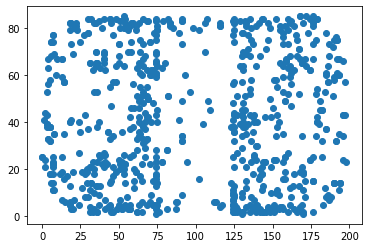

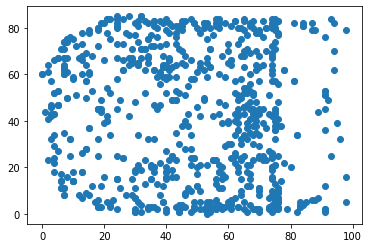

In [240]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
plt.scatter(powerplay.x_coord,powerplay.y_coord)

greater_100 = powerplay['x_coord']>100
less_100 = powerplay['x_coord']<100

#x flip
powerplay.loc[greater_100,powerplay.columns.str.contains("x_ft")] = 200 - powerplay.loc[greater_100, powerplay.columns.str.contains("x_ft")]
powerplay.loc[greater_100,powerplay.columns.str.contains("x_coord")] = 200 - powerplay.loc[greater_100, powerplay.columns.str.contains("x_coord")]
powerplay.loc[greater_100,powerplay.columns.str.contains("vel_x")] = -1*powerplay.loc[greater_100, powerplay.columns.str.contains("vel_x")]

#y flip, accounting for the rink rotation
powerplay.loc[less_100,powerplay.columns.str.contains("y_ft")] = 85 - powerplay.loc[less_100, powerplay.columns.str.contains("y_ft")]
powerplay.loc[less_100,powerplay.columns.str.contains("y_coord")] = 85 - powerplay.loc[less_100, powerplay.columns.str.contains("y_coord")]
powerplay.loc[less_100,powerplay.columns.str.contains("vel_y")] = -1*powerplay.loc[less_100, powerplay.columns.str.contains("vel_y")]

fig,ax = plt.subplots(1,1)
plt.scatter(powerplay.x_coord,powerplay.y_coord)

In [241]:
powerplay.to_csv("all_powerplays_new_method_11-24-22.csv",index=False)